## Feature selection

Hybrid method: Recursive feature elimination
This method consists of the following steps:

Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.

If the metric decreases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

Repeat steps 2-4 until all features have been evaluated.

I call this a hybrid method because:

it derives the importance derived from the machine learning algorithm, like embedded methods

it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice, it works extremely well. 

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop, the more features will be selected, and vice versa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,HipsSumVariancebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,0,81.3479,2,20.0,NaN,158.27,0.63,218.30,28.37,714.92,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,546.93,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,689.44,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,622.01,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,1,73.9726,2,24.0,0.11,233.02,0.48,229.88,39.46,686.51,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [8]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((366, 22), (158, 22))

In [9]:
model = GradientBoostingClassifier(random_state=42,)

# Define cross-validation strategy
scv = StratifiedKFold(n_splits=5, 
                      shuffle=True, 
                      random_state=42)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    estimator=model,
    scoring="roc_auc_ovr_weighted",
    threshold=0.0005,
    cv=scv
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train_t, y_train)

RecursiveFeatureElimination(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                            estimator=GradientBoostingClassifier(random_state=42),
                            scoring='roc_auc_ovr_weighted', threshold=0.0005)

In [10]:
# performance of model trained using all features

sel.initial_model_performance_

np.float64(0.884120131377364)

In [11]:
# drop in performance caused by shuffling the feature

sel.performance_drifts_

{'ERCsASMbaseline': np.float64(0.001204747463665501),
 'HipsASMbaseline': np.float64(0.00017830596784629282),
 'HipsSumAveragebaseline': np.float64(-0.006592674815907862),
 'Gender': np.float64(0.013751698966555592),
 'HipsClusterShadebaseline': np.float64(0.005118631741114599),
 'ERCsClusterShadebaseline': np.float64(0.007196415071289763),
 'HipsContrastbaseline': np.float64(0.005851081017783422),
 'HipsCorelationbaseline': np.float64(0.007506720273057765),
 'ERCsEntropybaseline': np.float64(0.0020575014252860457),
 'ERCsVariancebaseline': np.float64(0.006932755496997012),
 'ERCsSumVariancebaseline': np.float64(0.005542361931930029),
 'HipsVariancebaseline': np.float64(0.008373176867467969),
 'ERCsSumAveragebaseline': np.float64(0.0041468434033662405),
 'HipsSumVariancebaseline': np.float64(0.008040368317508872),
 'ERCsContrastbaseline': np.float64(0.004868265539637817),
 'ERCsCorelationbaseline': np.float64(0.00790651246862506),
 'ERCs_thicknessbaseline': np.float64(0.007022506359117

In [12]:
sel.feature_importances_

ERCsASMbaseline               0.003643
HipsASMbaseline               0.004489
HipsSumAveragebaseline        0.008816
Gender                        0.009675
HipsClusterShadebaseline      0.010477
ERCsClusterShadebaseline      0.014704
HipsContrastbaseline          0.015287
HipsCorelationbaseline        0.016297
ERCsEntropybaseline           0.016443
ERCsVariancebaseline          0.017260
ERCsSumVariancebaseline       0.018908
HipsVariancebaseline          0.020577
ERCsSumAveragebaseline        0.020663
HipsSumVariancebaseline       0.023278
ERCsContrastbaseline          0.024680
ERCsCorelationbaseline        0.025685
ERCs_thicknessbaseline        0.029870
HipposcampusVolumebaseline    0.036366
HipsEntropybaseline           0.042769
Ageatscreening                0.054983
ERCsVolumebaseline            0.065620
MMSE0m                        0.519510
dtype: float64

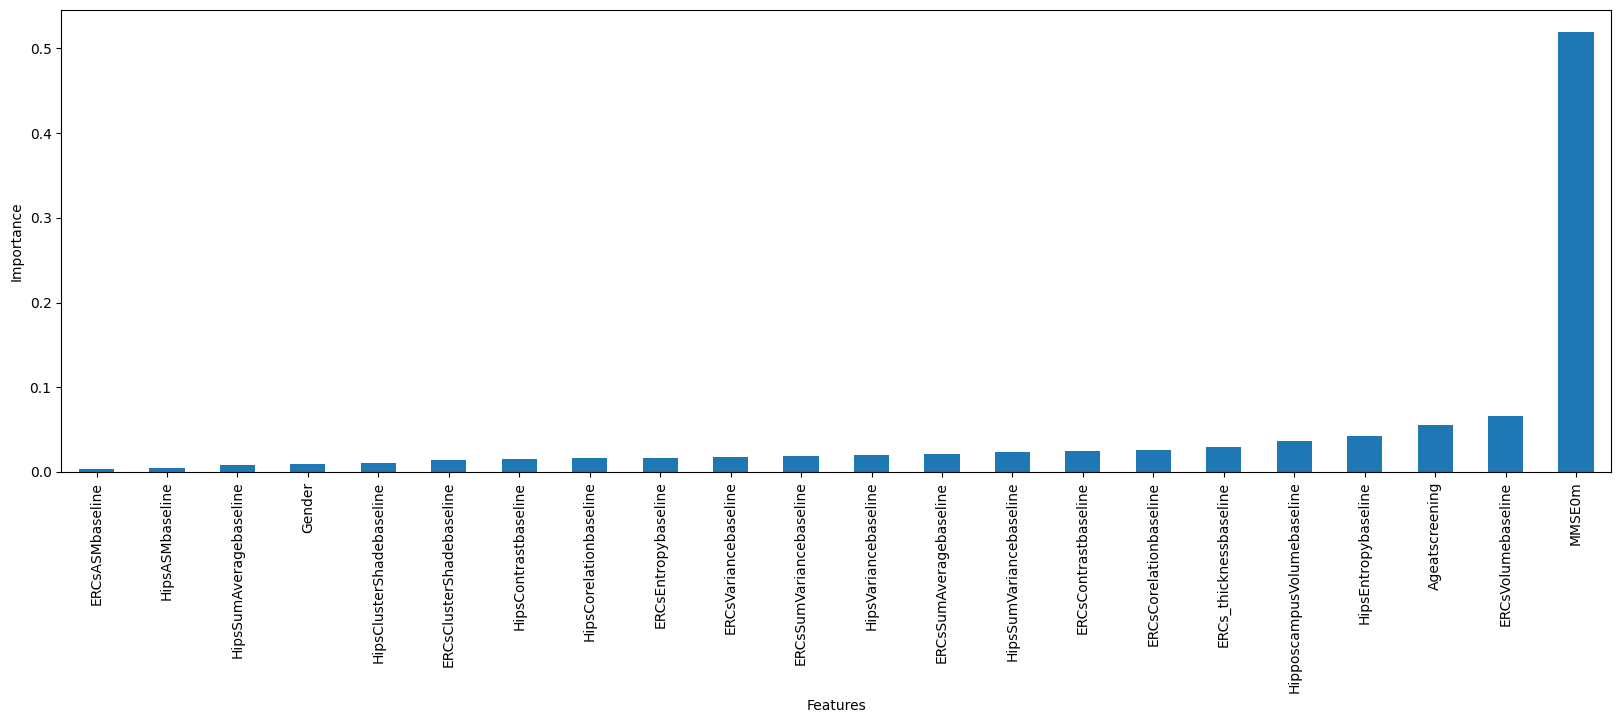

In [13]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

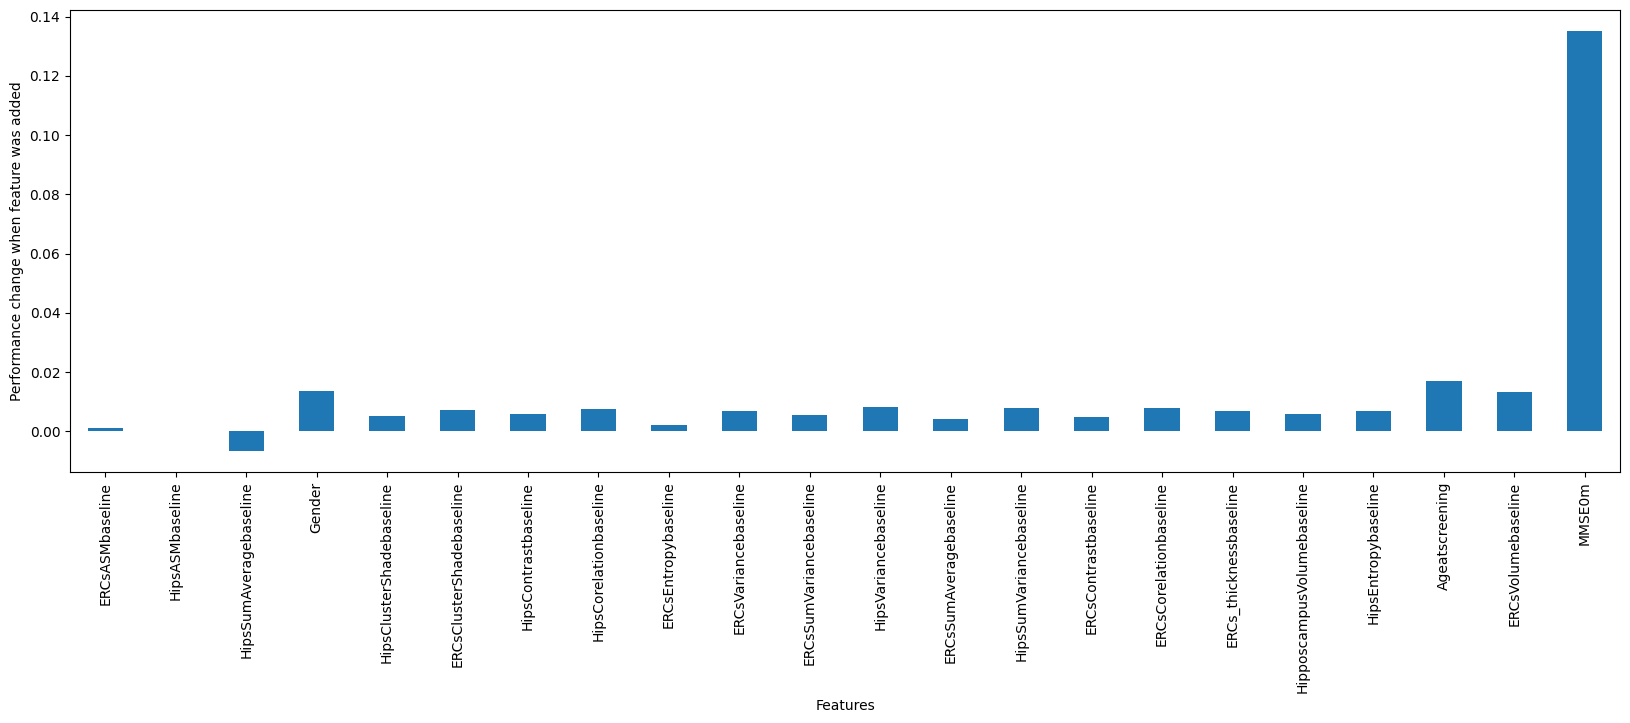

In [14]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [15]:
# Number of features that will be removed

sel.features_to_drop_

['HipsASMbaseline', 'HipsSumAveragebaseline']

In [16]:
# select features
X_train_t = sel.transform(X_train_missForest_t)
X_test_t = sel.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((366, 20), (158, 20))

## Classification Test

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)
        
        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False)
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )
                
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "ANOVA",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [18]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_missForest_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_missForest_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train)

In [19]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Metric", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Metric            Fit Time Total Features               
ANOVA             Random Forest       balanced_accuracy 0.492    22                   0.924   
                                                        0.439    20                   0.923   
                  XGBoost             balanced_accuracy 0.510    22                   1.000   
                                                        0.422    20                   1.000   
                  NGBoost             balanced_accuracy 1.886    22                   0.868   
                                                        1.903    20                   0.866   
                  Logistic Regression balanced_accuracy 0.036    22                   0.797   
                                                        0.025    20                   0.799   

                                                                                 Std Train  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.492    22                  0.007   
                                                        0.439    20                  0.007   
                  XGBoost             balanced_accuracy 0.510    22                  0.000   
                                                        0.422    20                  0.000   
                  NGBoost             balanced_accuracy 1.886    22                  0.011   
                                                        1.903    20                  0.013   
                  Logistic Regression balanced_accuracy 0.036    22                  0.014   
                                                        0.025    20                  0.013   

                                                                                 Mean Test  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.492    22                  0.752   
                                                        0.439    20                  0.735   
                  XGBoost             balanced_accuracy 0.510    22                  0.719   
                                                        0.422    20                  0.726   
                  NGBoost             balanced_accuracy 1.886    22                  0.739   
                                                        1.903    20                  0.741   
                  Logistic Regression balanced_accuracy 0.036    22                  0.754   
                                                        0.025    20                  0.770   

                                                                                 Std Test  
Feature Selection Classifier          Metric            Fit Time Total Features            
ANOVA             Random Forest       balanced_accuracy 0.492    22                 0.064  
                                                        0.439    20                 0.065  
                  XGBoost             balanced_accuracy 0.510    22                 0.069  
                                                        0.422    20                 0.076  
                  NGBoost             balanced_accuracy 1.886    22                 0.076  
                                                        1.903    20                 0.076  
                  Logistic Regression balanced_accuracy 0.036    22                 0.089  
                                                        0.025    20                 0.081

In [20]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)
        
        if classifier_name == "Logistic Regression":  
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)

        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "RFE",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [23]:
results = "filtered"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                             
RFE               Random Forest       0.324               20             accuracy                   0.904   
                                                                         balanced_accuracy          0.912   
                                                                         precision                  0.909   
                                                                         recall                     0.904   
                                                                         f1_weighted                0.902   
                                                                         roc_auc_ovr_weighted       0.982   
                  XGBoost             0.177               20             accuracy                   1.000   
                                                                         balanced_accuracy          1.000   
                                                                         precision                  1.000   
                                                                         recall                     1.000   
                                                                         f1_weighted                1.000   
                                                                         roc_auc_ovr_weighted       1.000   
                  NGBoost             0.434               20             accuracy                   0.852   
                                                                         balanced_accuracy          0.863   
                                                                         precision                  0.857   
                                                                         recall                     0.852   
                                                                         f1_weighted                0.849   
                                                                         roc_auc_ovr_weighted       0.967   
                  Logistic Regression 0.070               20             accuracy                   0.787   
                                                                         balanced_accuracy          0.794   
                                                                         precision                  0.785   
                                                                         recall                     0.787   
                                                                         f1_weighted                0.785   
                                                                         roc_auc_ovr_weighted       0.920   

                                                                                               Test data  
Feature Selection Classifier          Classification Time Total Features Metric                           
RFE               Random Forest       0.324               20             accuracy                  0.677  
                                                                         balanced_accuracy         0.690  
                                                                         precision                 0.670  
                                                                         recall                    0.677  
                                                                         f1_weighted               0.667  
                                                                         roc_auc_ovr_weighted      0.835  
                  XGBoost             0.177               20             accuracy                  0.671  
                                                                         balanced_accuracy         0.687  
                                                                         precision                 0.667  
                                                                         recall    